# Investigating Sliding Window Scores

The sliding window scores should have more overlap with the ground truth datasets than they do. I am going to go step-by-step to re-run the analysis, using the raw non-normalized sliding window scores from the method output file.

In [1]:
!hostnamectl

   Static hostname: psh01com1hcom01
         Icon name: computer-server
           Chassis: server
        Machine ID: 47b3d6fb06e0455987f8fbd8b72bfe4d
           Boot ID: c7eb6b77c2974a2f85c3c3f3710c29e2
  Operating System: ]8;;https://www.redhat.com/Red Hat Enterprise Linux 8.10 (Ootpa)]8;;
       CPE OS Name: cpe:/o:redhat:enterprise_linux:8::baseos
            Kernel: Linux 4.18.0-553.22.1.el8_10.x86_64
      Architecture: x86-64


In [ ]:
import os
import pandas as pd
import dev.notebooks.plotting as dev_plots

## Reload dev_plots

In [50]:
import importlib
importlib.reload(dev_plots)

<module 'dev.notebooks.plotting' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py'>

## Loading the Raw Sliding Window Scores

In [31]:
output_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/DS011_mESC/DS011_mESC_sample1/"

# Load sliding window scores, associate with the nearest gene TSS
raw_sliding_window_scores = pd.read_parquet(os.path.join(output_dir, "no_norm_sliding_window_tf_to_peak_score.parquet"), engine="pyarrow")
peaks_gene_distance_file = os.path.join(output_dir, "peaks_near_genes.parquet")

KeyboardInterrupt: 

## Mapping Sliding Window Scores to TGs

### Setting the TG as the closest gene TSS

First, we load in the raw sliding window scores from the direct output of the sliding window score calculation method, without normalization or scaling. 

To get TF-TG edges, we load in the dataframe of all peaks within 1 Mb of each gene and find the closest gene for each peak. We use the closest gene to each peak as the TG for each TF-peak edge in the sliding window scores.

In [ ]:
def set_tg_as_closest_gene_tss(raw_sliding_window_scores: pd.DataFrame, peaks_gene_distance_file: str):
    # Read in the peaks to TG data and pick the closest gene for each peak (maximum TSS distance score)
    peaks_near_genes_df = pd.read_parquet(peaks_gene_distance_file, engine="pyarrow")

    closest_gene_to_peak_df = peaks_near_genes_df.sort_values("TSS_dist_score", ascending=False).groupby("peak_id").first()
    closest_gene_to_peak_df = closest_gene_to_peak_df[["target_id"]].reset_index()

    # Set the TG for each TF-peak edge as the closest gene to the peak
    sliding_window_closest_gene_df = pd.merge(raw_sliding_window_scores, closest_gene_to_peak_df, on=["peak_id"], how="left")
    return sliding_window_closest_gene_df

In [ ]:
sliding_window_closest_gene_df = set_tg_as_closest_gene_tss(raw_sliding_window_scores, peaks_gene_distance_file)
    
sliding_window_tf_tg = sliding_window_closest_gene_df[["source_id", "target_id", "sliding_window_score"]].drop_duplicates()
unique_sliding_window_tf_tg_edges = sliding_window_tf_tg[["source_id", "target_id"]].drop_duplicates()

In [ ]:
print(f"Sliding Window scores")
print(f"  - TFs: {sliding_window_tf_tg['source_id'].nunique():,}")
print(f"  - TGs: {sliding_window_tf_tg['target_id'].nunique():,}")
print(f"  - TF-peak-TG Edges: {len(sliding_window_closest_gene_df):,}")
print(f"  - TF-TG-Score Edges: {len(sliding_window_tf_tg):,}")
print(f"  - TF-TG Edges: {len(unique_sliding_window_tf_tg_edges):,}")

Sliding Window scores
  - TFs: 911
  - TGs: 23,144
  - TF-peak-TG Edges: 174,209,619
  - TF-TG-Score Edges: 162,275,577
  - TF-TG Edges: 21,084,184


### Setting the TG using MIRA peak-TG

In [ ]:
mira_peak_to_tg_df = pd.read_parquet("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_full/ds011_full_mira_peak_to_tg_scores.parquet", engine="pyarrow")

In [ ]:
def set_tg_using_mira_peak_tg_edges(raw_sliding_window_scores: pd.DataFrame, mira_df: pd.DataFrame):
    sliding_window_mira_df = pd.merge(raw_sliding_window_scores, mira_df, on=["peak_id"], how="left")
    sliding_window_mira_df = sliding_window_mira_df[["source_id", "peak_id", "target_id", "sliding_window_score"]].dropna(subset="target_id")
    
    return sliding_window_mira_df

In [ ]:
sliding_window_mira_df = set_tg_using_mira_peak_tg_edges(raw_sliding_window_scores, mira_peak_to_tg_df)
sliding_window_mira_df

,source_id,peak_id,target_id,sliding_window_score
2,Ahctf1,chr17:33978387-33979255,H2-K1,9915.335731
7,Ahctf1,chr17:28987528-28988389,BC004004,11529.230783
14,Ahctf1,chr17:34813543-34814423,H2-D1,10134.219388
15,Ahctf1,chr17:34813543-34814423,H2-Q4,10134.219388
24,Ahctf1,chr17:31728710-31729584,AC166172.1,10749.064743
...,...,...,...,...
174697535,Dnajc21,chr11:113291916-113292828,BC006965,17922.005784
174697550,Dnajc21,chr11:113266466-113267336,BC006965,16997.607625
174697561,Dnajc21,chr11:113268634-113269524,BC006965,17285.392999
174697571,Dnajc21,chr11:113284904-113285728,BC006965,16162.776374


### Setting the TG using Cicero peak-TG

In [ ]:
cicero_peak_to_tg_df = pd.read_parquet(os.path.join(output_dir, "cicero_peak_to_tg_scores.parquet"), engine="pyarrow")

In [ ]:
def set_tg_using_cicero_peak_tg_edges(raw_sliding_window_scores: pd.DataFrame, cicero_df: pd.DataFrame):
    sliding_window_cicero_df = pd.merge(raw_sliding_window_scores, cicero_df, on=["peak_id"], how="left")
    sliding_window_cicero_df = sliding_window_cicero_df[["source_id", "peak_id", "target_id", "sliding_window_score"]].dropna(subset="target_id")
    
    return sliding_window_cicero_df

In [ ]:
sliding_window_cicero_df = set_tg_using_cicero_peak_tg_edges(raw_sliding_window_scores, cicero_peak_to_tg_df)
sliding_window_cicero_df

,source_id,peak_id,target_id,sliding_window_score
46,Ahctf1,chr17:45457243-45458071,Runx2os2,11055.363027
47,Ahctf1,chr17:45457243-45458071,Gm55654,11055.363027
48,Ahctf1,chr17:45457243-45458071,B230354K17Rik,11055.363027
102,Ahctf1,chr17:15622638-15623551,Gm35455,12543.224156
103,Ahctf1,chr17:15622638-15623551,Gm7423,12543.224156
...,...,...,...,...
180310432,Dnajc21,chr11:24286398-24287277,Gm33440,17153.920234
180311059,Dnajc21,chr11:85941659-85942561,Bcas3os1,17653.594830
180311060,Dnajc21,chr11:85941659-85942561,Gm56240,17653.594830
180311061,Dnajc21,chr11:85941659-85942561,Tbx4,17653.594830


## Loading RN115

Next, we load in the RN115 LOGOF ESCAPE ground truth data and ensure that the TF and TG column names match the sliding window DataFrame columns

In [ ]:
# Load the RN115 LOGOG ESCAPE ground truth
rn115_ko_ground_truth = pd.read_csv("/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SC_MO_TRN_DB.MIRA/REPOSITORY/CURRENT/REFERENCE_NETWORKS/RN115_LOGOF_ESCAPE_Mouse_ESC.tsv", sep="\t")
rn115_ko_ground_truth = rn115_ko_ground_truth[["Source", "Target"]].rename(columns={"Source":"source_id", "Target":"target_id"})
rn115_ko_ground_truth["source_id"] = rn115_ko_ground_truth["source_id"].str.capitalize()
rn115_ko_ground_truth["target_id"] = rn115_ko_ground_truth["target_id"].str.capitalize()

In [ ]:
print("RN115 LOGOF Ground Truth")
print(f"  - TFs: {rn115_ko_ground_truth['source_id'].nunique():,}")
print(f"  - TGs: {rn115_ko_ground_truth['target_id'].nunique():,}")
print(f"  - Edges: {len(rn115_ko_ground_truth):,}")

RN115 LOGOF Ground Truth
  - TFs: 55
  - TGs: 16,522
  - Edges: 109,068


### RN115 TGs per TF

In [ ]:
rn115_targets_per_tf = rn115_ko_ground_truth.groupby("source_id").count().sort_values(by="target_id", ascending=False)
print("Number of RN115 TGs per TF")
rn115_targets_per_tf

Number of RN115 TGs per TF


,target_id
source_id,
Pou5f1,7160
Tcf3,7094
Klf4,7015
Sox2,6177
Esx1,5882
Sox9,5821
Gata3,4757
Eomes,3835
Nrip1,3585


In [ ]:
sliding_window_tf_tg

,source_id,target_id,sliding_window_score
0,Ahctf1,Agpat4,10759.024472
1,Ahctf1,Birc6,12004.494425
2,Ahctf1,Rab11b,9915.335731
3,Ahctf1,Cyp4f15,6876.511407
4,Ahctf1,Gm34567,9358.360679
...,...,...,...
174209614,Dnajc21,Abca13,13089.834027
174209615,Dnajc21,Gm12081,17225.857550
174209616,Dnajc21,Abca13,17721.553265
174209617,Dnajc21,Abca13,17403.041555


### Sliding Window TGs per TF

In [ ]:
sliding_window_targets_per_tf = sliding_window_tf_tg.groupby("source_id")["target_id"].count().sort_values(ascending=False)
print("Number of Sliding Window TGs per TF")
sliding_window_targets_per_tf

Number of Sliding Window TGs per TF


source_id
Zzz3      191229
Ahctf1    191229
Ahr       191229
Aire      191229
Alx1      191229
           ...  
Zfp521     23144
Zfp541     23144
Zfp628     23144
Zfp664     23144
Zfp697     23144
Name: target_id, Length: 911, dtype: int64

## Overlap between RN115 and Sliding Window Scores

Merge the datasets together. By doing a full outer join and using `inticator=True`, we can separate out the edges in both datasets along with the edges only in the sliding window scores and the edges only in RN115

In [ ]:
merged_edges = pd.merge(
    sliding_window_tf_tg, 
    rn115_ko_ground_truth, 
    on=["source_id", "target_id"], 
    how="outer",
    indicator=True
    )
merged_edges

,source_id,target_id,sliding_window_score,_merge
0,Aes,0610005c13rik,NaN,right_only
1,Aes,0610012h03rik,NaN,right_only
2,Aes,1110006g14rik,NaN,right_only
3,Aes,1200009o22rik,NaN,right_only
4,Aes,1600029d21rik,NaN,right_only
...,...,...,...,...
162351560,Zzz3,a,15238.133570,left_only
162351561,Zzz3,a,15178.787101,left_only
162351562,Zzz3,a,15040.493744,left_only
162351563,Zzz3,a,10598.533027,left_only


In [ ]:
edges_in_both = merged_edges[merged_edges["_merge"] == "both"].drop(columns="_merge")
sliding_window_edges_only = merged_edges[merged_edges["_merge"] == "left_only"].drop(columns="_merge")
rn115_edges_only = merged_edges[merged_edges["_merge"] == "right_only"].drop(columns="_merge")

In [ ]:
tfs_in_both = edges_in_both["source_id"].drop_duplicates()
tgs_in_both = edges_in_both["target_id"].drop_duplicates()

print("Edges in both RN115 and Sliding Window:")
print(f"  - TFs in both: {len(tfs_in_both):,}")
print(f"  - TGs in both: {len(tgs_in_both):,}")
print(f"  - TF-TG-Score Edges in both: {len(edges_in_both):,}")
print(f"  - TF-TG Edges in both: {len(edges_in_both.drop_duplicates(subset=['source_id', 'target_id'])):,}")

Edges in both RN115 and Sliding Window:
  - TFs in both: 40
  - TGs in both: 9,439
  - TF-TG-Score Edges in both: 547,514
  - TF-TG Edges in both: 55,316


In [ ]:
tfs_only_in_sliding_window = sliding_window_tf_tg[~sliding_window_tf_tg["source_id"].isin(rn115_ko_ground_truth["source_id"])]["source_id"].drop_duplicates()
tgs_only_in_sliding_window = sliding_window_tf_tg[~sliding_window_tf_tg["target_id"].isin(rn115_ko_ground_truth["target_id"])]["target_id"].drop_duplicates()

print("Only in Sliding Window:")
print(f"  - TFs only in Sliding Window: {len(tfs_only_in_sliding_window):,}")
print(f"  - TGs only in Sliding Window: {len(tgs_only_in_sliding_window):,}")
print(f"  - TF-peak-TG Edges only in Sliding Window: {len(sliding_window_edges_only):,}")
print(f"  - TF-TG Edges only in Sliding Window: {len(sliding_window_edges_only.drop_duplicates(subset=['source_id', 'target_id'])):,}")

Only in Sliding Window:
  - TFs only in Sliding Window: 871
  - TGs only in Sliding Window: 13,398
  - TF-peak-TG Edges only in Sliding Window: 161,754,084
  - TF-TG Edges only in Sliding Window: 21,028,868


In [ ]:
tfs_only_in_rn115 = rn115_ko_ground_truth[~rn115_ko_ground_truth["source_id"].isin(sliding_window_tf_tg["source_id"])]["source_id"].drop_duplicates()
tgs_only_in_rn115 = rn115_ko_ground_truth[~rn115_ko_ground_truth["target_id"].isin(sliding_window_tf_tg["target_id"])]["target_id"].drop_duplicates()

print("Only in RN115:")
print(f"  - TFs only in RN115: {len(tfs_only_in_rn115):,}")
print(f"  - TGs only in RN115: {len(tgs_only_in_rn115):,}")
print(f"  - Edges only in Sliding Window: {len(rn115_edges_only):,}")

Only in RN115:
  - TFs only in RN115: 15
  - TGs only in RN115: 6,776
  - Edges only in Sliding Window: 49,967


### Sum of sliding window scores per TF-TG edge (strength of association)

#### Both Sliding Window and RN115

In [ ]:
edges_in_both_by_tf_tg = (
    edges_in_both.groupby(["source_id", "target_id"])
    .count()
    .sort_values(by="sliding_window_score", ascending=False)
    .reset_index()
    .rename(columns={'sliding_window_score':'Num Scores per TF-TG Edge'})
)
edges_in_both_by_tf_tg

,source_id,target_id,Num Scores per TF-TG Edge
0,Sox2,Slit3,248
1,Sox2,Bnc2,234
2,Sox2,Kalrn,216
3,Tcf3,Pde4d,179
4,Sox2,Pde4d,179
...,...,...,...
55311,Ascl1,Akr1c13,1
55312,Ascl1,Ang2,1
55313,Zscan4c,Vasn,1
55314,Zscan4c,Vpreb3,1


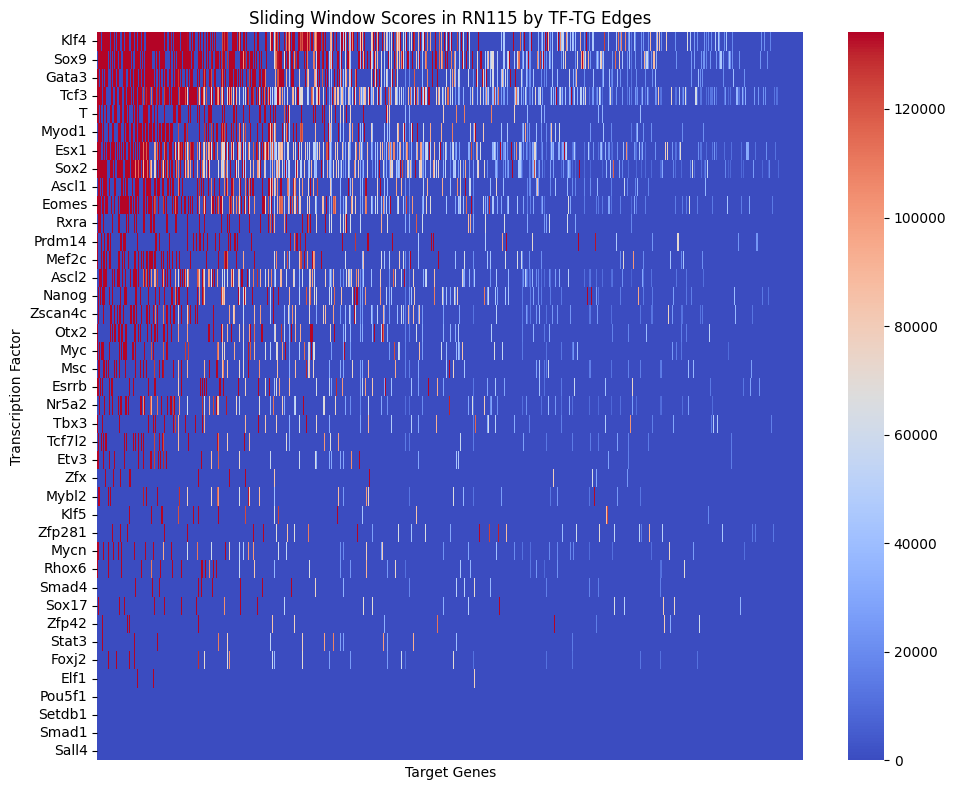

In [ ]:
importlib.reload(dev_plots)
dev_plots.plot_score_heatmap_by_tf_tg(
    df=edges_in_both,
    title="Sliding Window Scores in RN115 by TF-TG Edges",
    score_col="sliding_window_score",
    max_tfs=edges_in_both["source_id"].nunique(),
    max_tgs=edges_in_both["target_id"].nunique()
    )

#### Only in Sliding Window

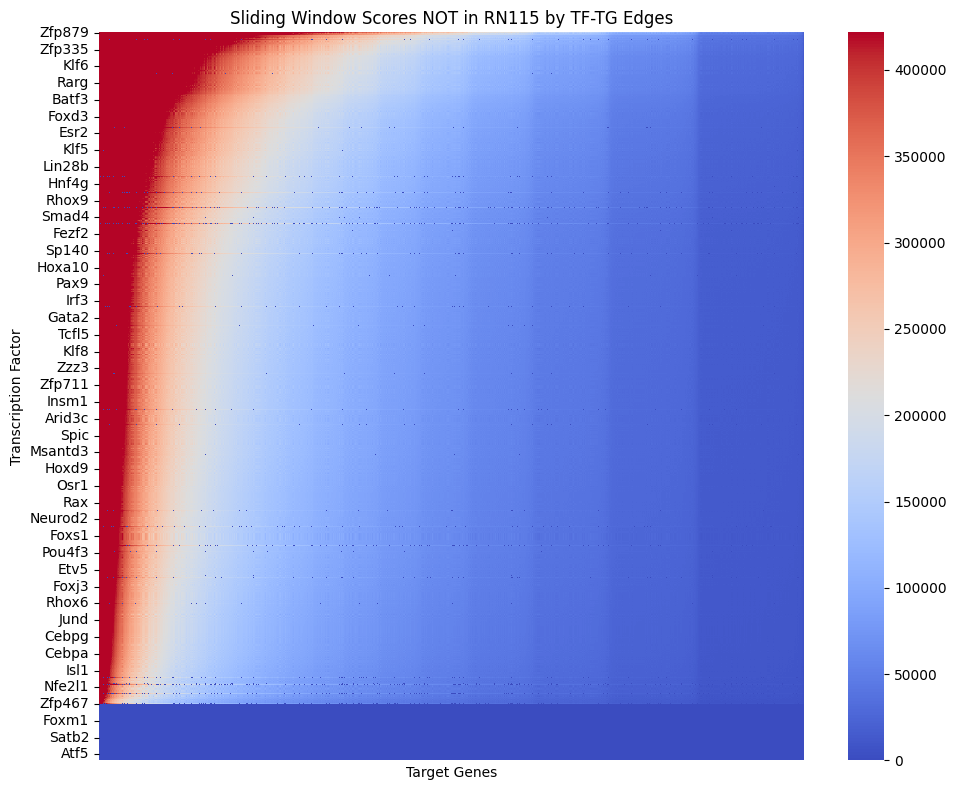

In [ ]:
dev_plots.plot_score_heatmap_by_tf_tg(
    df=sliding_window_edges_only,
    title="Sliding Window Scores NOT in RN115 by TF-TG Edges",
    score_col="sliding_window_score",
    max_tfs=sliding_window_edges_only["source_id"].nunique(),
    max_tgs=sliding_window_edges_only["target_id"].nunique()
    )

In [ ]:
sliding_window_edges_only_only_by_tf_tg = (
    sliding_window_edges_only.groupby(["source_id", "target_id"])
    .count()
    .sort_values(by="sliding_window_score", ascending=False)
    .reset_index()
    .rename(columns={'sliding_window_score':'Num Scores per TF-TG Edge'})
)
sliding_window_edges_only_only_by_tf_tg

,source_id,target_id,Num Scores per TF-TG Edge
0,Phox2b,Pde4d,179
1,Zfp146,Pde4d,179
2,Barhl2,Pde4d,179
3,Msx1,Pde4d,179
4,Zfp382,Pde4d,179
...,...,...,...
21028863,Zzz3,Znrd2,1
21028864,Olig2,Ciao1,1
21028865,Olig2,Ciao3,1
21028866,Olig2,Cib3,1


### Number of scores per TF

#### Both Sliding Window and RN115

In [ ]:
edges_in_both_by_tf = (
    edges_in_both
    .groupby("source_id")
    .count()
    .sort_values("target_id", ascending=False)
    .rename(columns={'sliding_window_score':'Num Scores per TF'})
    ['Num Scores per TF']
    .reset_index()
    )

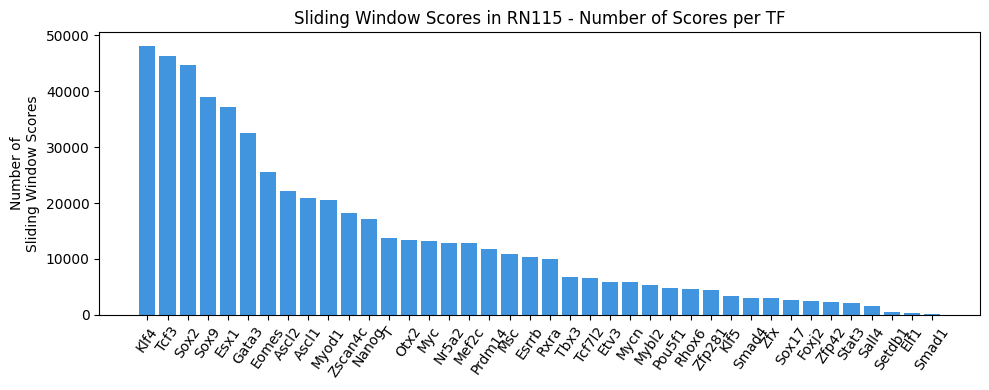

In [ ]:
importlib.reload(dev_plots)
dev_plots.plot_scores_grouped_by_tf(
    edges_in_both, 
    title="Sliding Window Scores in RN115 - Number of Scores per TF", 
    score_col="sliding_window_score"
    )

#### Only in Sliding Window

In [ ]:
sliding_window_edges_only_by_tf = (
    sliding_window_edges_only
    .groupby("source_id")
    .count()
    .sort_values("target_id", ascending=False)
    .rename(columns={'sliding_window_score':'Num Scores per TF'})
    ['Num Scores per TF']
    .reset_index()
    )

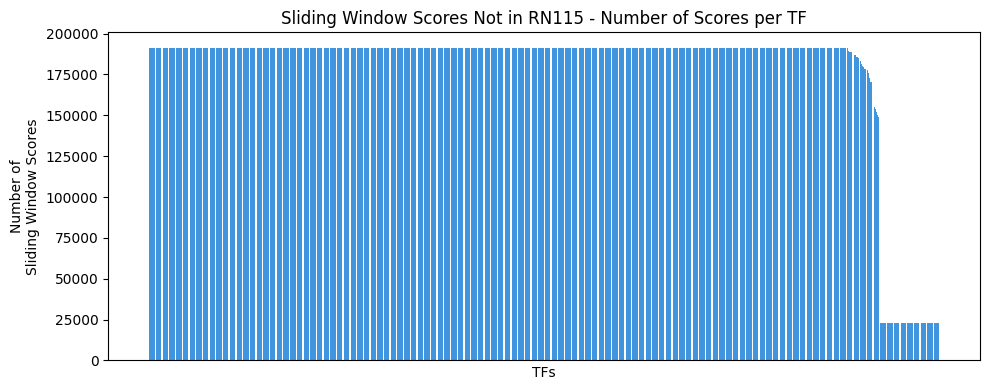

In [ ]:
importlib.reload(dev_plots)
dev_plots.plot_scores_grouped_by_tf(
    sliding_window_edges_only, 
    title="Sliding Window Scores Not in RN115 - Number of Scores per TF", 
    score_col="sliding_window_score",
    top_tf_limit=911
    )

array([[<Axes: title={'center': 'sliding_window_score'}>]], dtype=object)

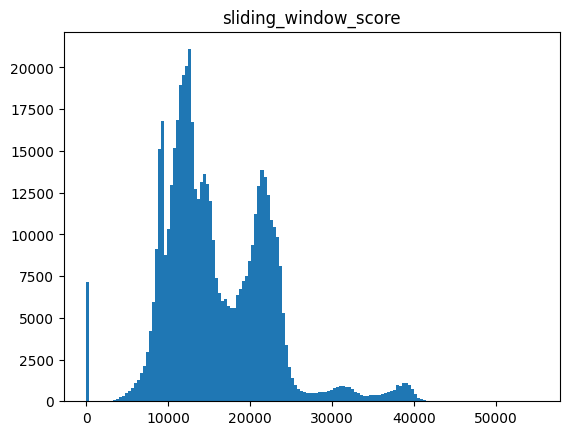

In [ ]:
edges_in_both.hist("sliding_window_score", bins=150, grid=False)

## Score Distributions - Edges in RN115 vs Edges Not in RN115

In [ ]:
importlib.reload(dev_plots)
dev_plots.plot_true_false_distribution(
    true_series=edges_in_both["sliding_window_score"], 
    false_series=sliding_window_edges_only["sliding_window_score"],
    xlabel="Sliding Window Score",
    title="Sliding Window Scores",
    balance=True
    
    )

NameError: name 'importlib' is not defined

INFO: Limiting to scores from the top 15 TFs, found 15


100%|██████████| 15/15 [00:01<00:00,  9.98it/s]                                                                                               


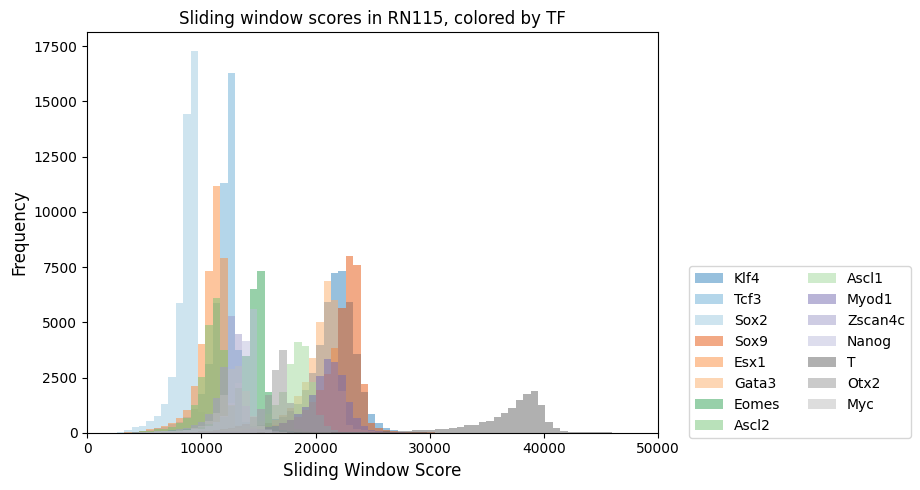

INFO: Limiting to scores from the top 15 TFs, found 15


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]                                                                                               


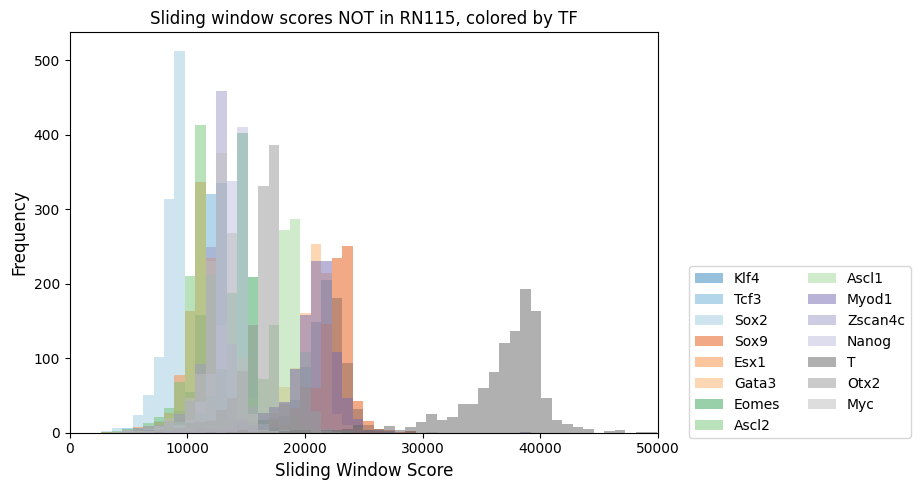

In [ ]:
importlib.reload(dev_plots)

df = (
    edges_in_both
    .groupby("source_id")
    .count()
    .sort_values("sliding_window_score", ascending=False)
    .reset_index()
    )
tfs_of_interest = df["source_id"].drop_duplicates().to_list()

num_tfs = 15

dev_plots.plot_score_distribution_by_tf(
    df=edges_in_both, 
    score_col="sliding_window_score", 
    title="Sliding window scores in RN115, colored by TF",
    top_tf_limit=num_tfs,
    tfs_of_interest=tfs_of_interest
    )
dev_plots.plot_score_distribution_by_tf(
    df=sliding_window_edges_only, 
    score_col="sliding_window_score", 
    title="Sliding window scores NOT in RN115, colored by TF",
    top_tf_limit=num_tfs,
    tfs_of_interest = tfs_of_interest
    )

## Comparing Sliding Window Scores to RN111

### Size of RN111

In [ ]:
from grn_inference.utils import read_ground_truth
rn111_chipseq_ground_truth = read_ground_truth("/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SC_MO_TRN_DB.MIRA/REPOSITORY/CURRENT/REFERENCE_NETWORKS/RN111_ChIPSeq_BEELINE_Mouse_ESC.tsv").drop(columns=["Relationship"])
rn111_chipseq_ground_truth['source_id'] = rn111_chipseq_ground_truth['source_id'].str.capitalize()
rn111_chipseq_ground_truth['target_id'] = rn111_chipseq_ground_truth['target_id'].str.capitalize()

In [ ]:
print("RN111 ChIP-seq Ground Truth")
print(f"  - TFs: {rn111_chipseq_ground_truth['source_id'].nunique():,}")
print(f"  - TGs: {rn111_chipseq_ground_truth['target_id'].nunique():,}")
print(f"  - Edges: {len(rn111_chipseq_ground_truth):,}")

RN111 ChIP-seq Ground Truth
  - TFs: 247
  - TGs: 25,700
  - Edges: 977,841


### RN111 TGs per TF

In [ ]:
rn111_targets_per_tf = rn111_chipseq_ground_truth.groupby("source_id").count().sort_values(by="target_id", ascending=False)
print("Number of RN111 TGs per TF")
rn111_targets_per_tf

Number of RN111 TGs per TF


,target_id
source_id,
Nanog,17503
Pou5f1,14685
Utf1,14299
Gabbr1,14167
Dr1,13878
...,...
Baz2a,1
Lmnb1,1
Gcm1,1


## Overlap between sliding window scores and RN111

In [ ]:
merged_edges = pd.merge(
    sliding_window_tf_tg, 
    rn111_chipseq_ground_truth, 
    on=["source_id", "target_id"], 
    how="outer",
    indicator=True
    )

In [ ]:
edges_in_sliding_and_rn111 = merged_edges[merged_edges["_merge"] == "both"].drop(columns="_merge")
sliding_window_not_rn111_edges = merged_edges[merged_edges["_merge"] == "left_only"].drop(columns="_merge")
rn111_edges_only = merged_edges[merged_edges["_merge"] == "right_only"].drop(columns="_merge")

In [ ]:
tfs_in_both = edges_in_sliding_and_rn111["source_id"].drop_duplicates()
tgs_in_both = edges_in_sliding_and_rn111["target_id"].drop_duplicates()

print("Edges in both RN111 and Sliding Window:")
print(f"  - TFs in both: {len(tfs_in_both):,}")
print(f"  - TGs in both: {len(tgs_in_both):,}")
print(f"  - TF-TG-Score Edges in both: {len(edges_in_sliding_and_rn111):,}")
print(f"  - TF-TG Edges in both: {len(edges_in_sliding_and_rn111.drop_duplicates(subset=['source_id', 'target_id'])):,}")

Edges in both RN111 and Sliding Window:
  - TFs in both: 75
  - TGs in both: 14,072
  - TF-TG-Score Edges in both: 2,003,506
  - TF-TG Edges in both: 256,038


In [ ]:
tfs_only_in_sliding_window = sliding_window_tf_tg[~sliding_window_tf_tg["source_id"].isin(rn111_chipseq_ground_truth["source_id"])]["source_id"].drop_duplicates()
tgs_only_in_sliding_window = sliding_window_tf_tg[~sliding_window_tf_tg["target_id"].isin(rn111_chipseq_ground_truth["target_id"])]["target_id"].drop_duplicates()

print("Sliding window but NOT RN111:")
print(f"  - TFs: {len(tfs_only_in_sliding_window):,}")
print(f"  - TGs: {len(tgs_only_in_sliding_window):,}")
print(f"  - TF-peak-TG Edges: {len(sliding_window_not_rn111_edges):,}")
print(f"  - TF-TG Edges: {len(sliding_window_not_rn111_edges.drop_duplicates(subset=['source_id', 'target_id'])):,}")

Sliding window but NOT RN111:
  - TFs: 836
  - TGs: 8,834
  - TF-peak-TG Edges: 160,272,071
  - TF-TG Edges: 20,828,146


In [ ]:
tfs_only_in_rn111 = rn111_chipseq_ground_truth[~rn111_chipseq_ground_truth["source_id"].isin(sliding_window_tf_tg["source_id"])]["source_id"].drop_duplicates()
tgs_only_in_rn111 = rn111_chipseq_ground_truth[~rn111_chipseq_ground_truth["target_id"].isin(sliding_window_tf_tg["target_id"])]["target_id"].drop_duplicates()

print("Only in RN111:")
print(f"  - TFs only in RN111: {len(tfs_only_in_rn111):,}")
print(f"  - TGs only in RN111: {len(tgs_only_in_rn111):,}")
print(f"  - Edges only in RN111: {len(rn111_edges_only):,}")

Only in RN111:
  - TFs only in RN111: 172
  - TGs only in RN111: 11,390
  - Edges only in RN111: 721,803


### Sum of sliding window scores per TF-TG Edge (strength of association)

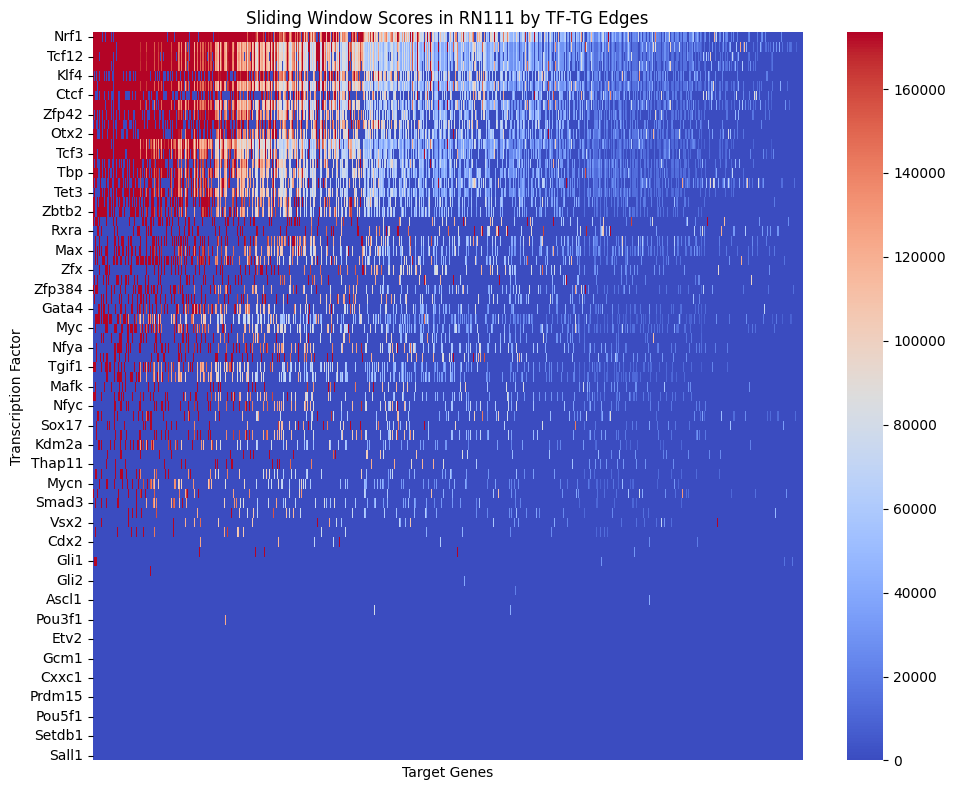

In [ ]:
dev_plots.plot_score_heatmap_by_tf_tg(
    df=edges_in_sliding_and_rn111,
    title="Sliding Window Scores in RN111 by TF-TG Edges",
    score_col="sliding_window_score",
    max_tfs=edges_in_sliding_and_rn111["source_id"].nunique(),
    max_tgs=edges_in_sliding_and_rn111["target_id"].nunique()
    )

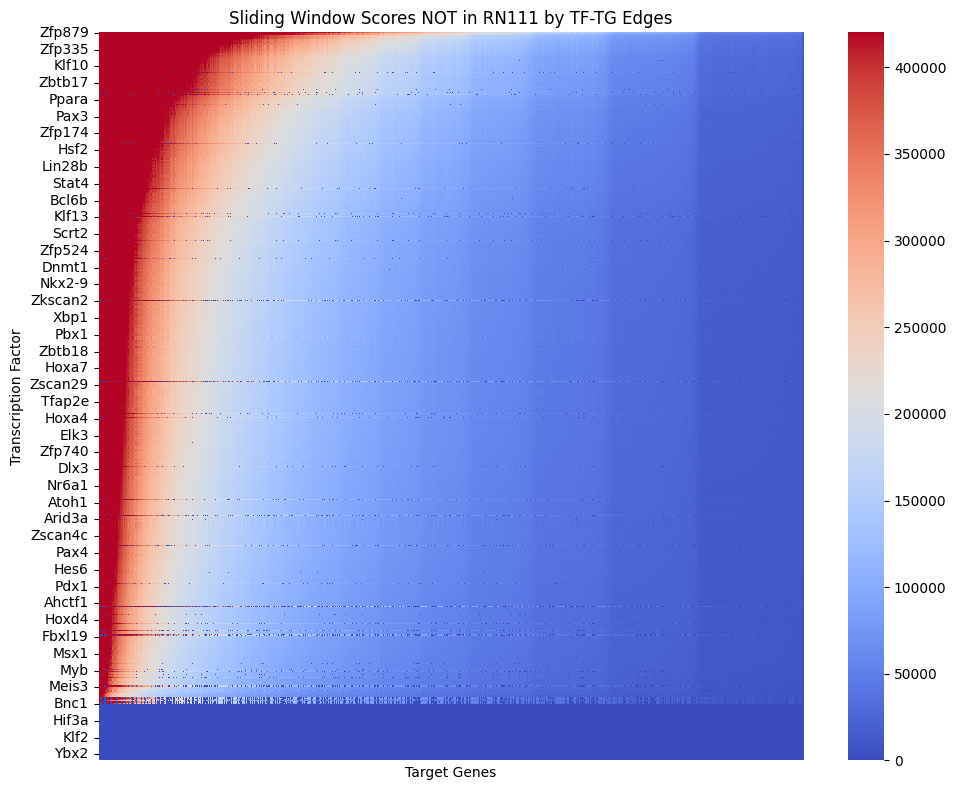

In [ ]:
dev_plots.plot_score_heatmap_by_tf_tg(
    df=sliding_window_not_rn111_edges,
    title="Sliding Window Scores NOT in RN111 by TF-TG Edges",
    score_col="sliding_window_score",
    max_tfs=sliding_window_not_rn111_edges["source_id"].nunique(),
    max_tgs=sliding_window_not_rn111_edges["target_id"].nunique()
    )

### Number of Scores per TF

#### Both Sliding Window and RN111

In [ ]:
edges_in_sliding_and_rn111_by_tf = (
    edges_in_sliding_and_rn111
    .groupby("source_id")
    .count()
    .sort_values("target_id", ascending=False)
    .rename(columns={'sliding_window_score':'Num Scores per TF'})
    ['Num Scores per TF']
    .reset_index()
    )

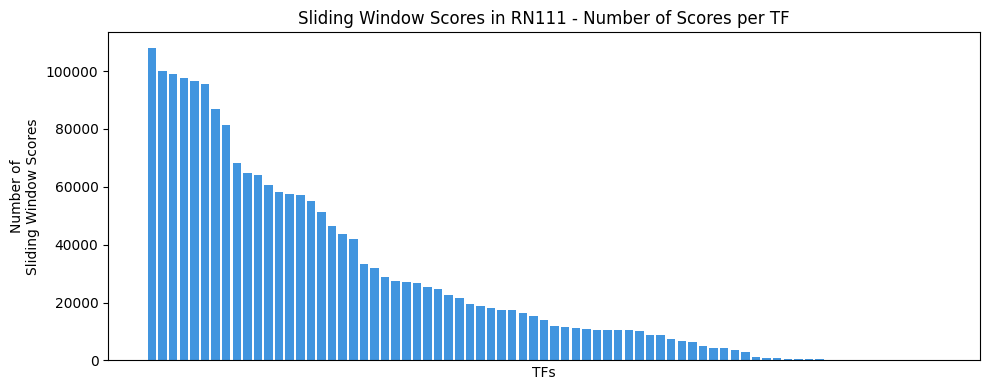

In [ ]:
importlib.reload(dev_plots)
dev_plots.plot_scores_grouped_by_tf(
    edges_in_sliding_and_rn111, 
    title="Sliding Window Scores in RN111 - Number of Scores per TF", 
    score_col="sliding_window_score",
    top_tf_limit=75
    )

#### Only in Sliding Window

In [ ]:
sliding_window_not_rn111_edges_by_tf = (
    sliding_window_not_rn111_edges
    .groupby("source_id")
    .count()
    .sort_values("target_id", ascending=False)
    .rename(columns={'sliding_window_score':'Num Scores per TF'})
    ['Num Scores per TF']
    .reset_index()
    )

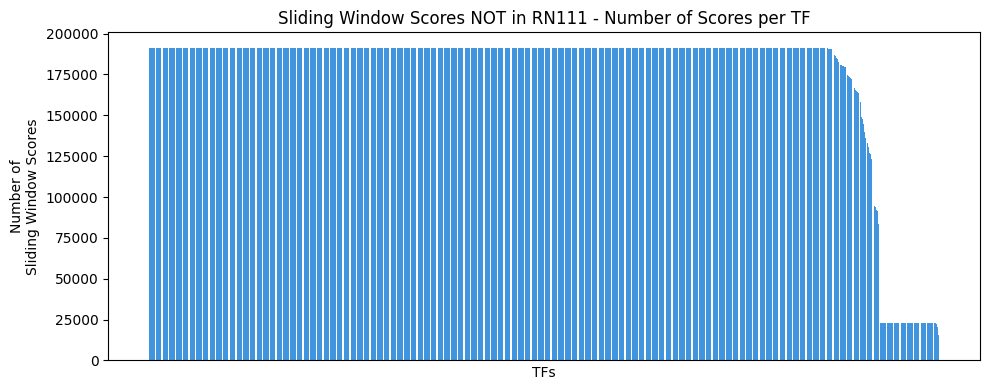

In [ ]:
importlib.reload(dev_plots)
dev_plots.plot_scores_grouped_by_tf(
    sliding_window_not_rn111_edges, 
    title="Sliding Window Scores NOT in RN111 - Number of Scores per TF", 
    score_col="sliding_window_score",
    top_tf_limit=911
    )

## Score Distributions - Edges in RN111 vs Edges Not in RN111

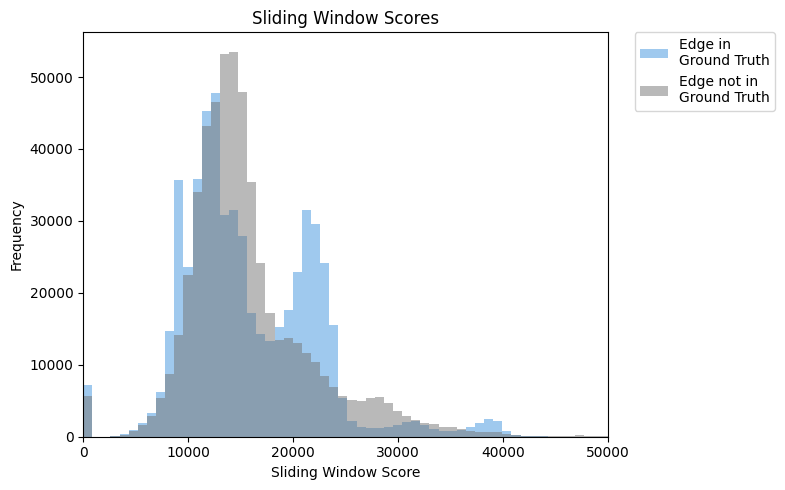

In [ ]:
importlib.reload(dev_plots)
dev_plots.plot_true_false_distribution(
    true_series=edges_in_both["sliding_window_score"], 
    false_series=sliding_window_edges_only["sliding_window_score"],
    xlabel="Sliding Window Score",
    title="Sliding Window Scores",
    balance=True
    )

INFO: Limiting to scores from the top 15 TFs, found 15


100%|██████████| 15/15 [00:02<00:00,  5.05it/s]                                                                                               


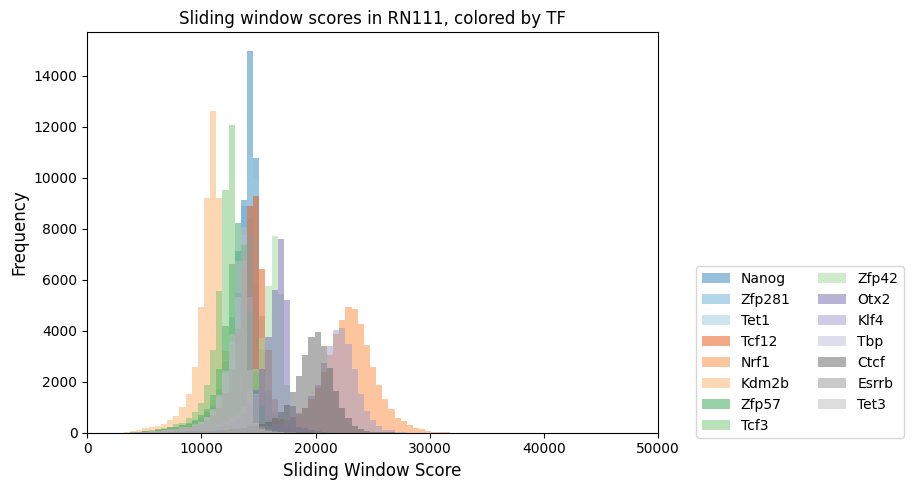

INFO: Limiting to scores from the top 15 TFs, found 15


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]                                                                                               


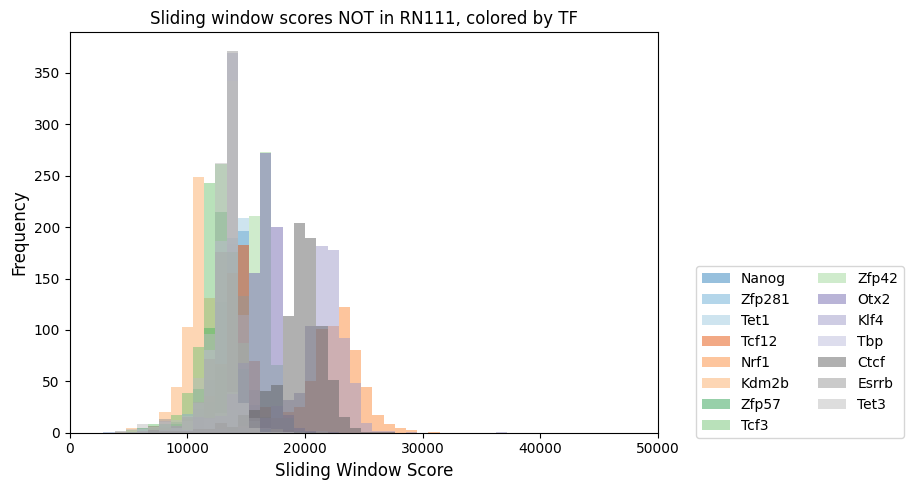

In [ ]:
importlib.reload(dev_plots)

df = (
    edges_in_sliding_and_rn111
    .groupby("source_id")
    .count()
    .sort_values("sliding_window_score", ascending=False)
    .reset_index()
    )
tfs_of_interest = df["source_id"].drop_duplicates().to_list()

num_tfs = 15

dev_plots.plot_score_distribution_by_tf(
    df=edges_in_sliding_and_rn111, 
    score_col="sliding_window_score", 
    title="Sliding window scores in RN111, colored by TF",
    top_tf_limit=num_tfs,
    tfs_of_interest=tfs_of_interest
    )
dev_plots.plot_score_distribution_by_tf(
    df=sliding_window_not_rn111_edges, 
    score_col="sliding_window_score", 
    title="Sliding window scores NOT in RN111, colored by TF",
    top_tf_limit=num_tfs,
    tfs_of_interest = tfs_of_interest
    )